# Project: Image Classification and Regression

Name: Tong ZHAO

Email: tong.zhao@eleves.enpc.fr

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

import numpy as np

%matplotlib inline

## Parameters

In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

## Dataset Generator

A parameter *pair* is added to return a pair of drawing for the denoising task.

### Generate a Drawing

In [5]:
def generate_a_drawing(figsize, U, V, noise=0.0, pair=True):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    
    if pair:
        return imdata, imdata_noise
    else:
        return imdata_noise

In [6]:
def generate_a_rectangle(noise=0.0, free_location=False, pair=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise, pair=pair)

In [7]:
def generate_a_disk(noise=0.0, free_location=False, pair=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise, pair=pair)

In [8]:
def generate_a_triangle(noise=0.0, free_location=False, pair=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise, pair=pair)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

Some examples are shown below.

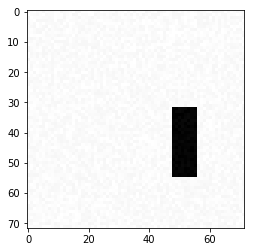

In [9]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

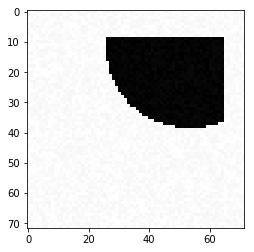

In [10]:
im = generate_a_disk(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

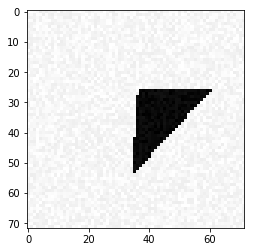

In [11]:
[im, v] = generate_a_triangle(20, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

### Generate a Dataset

In [12]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [13]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [14]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [15]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## Visualization Functions

In [16]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [25]:
def plot_classifier_history(history):
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.title("Accuracy on Train")
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss on Train")
    plt.grid()
    
    plt.show()
    
    print("Final Accuracy on Train: %f" % history.history['acc'][-1])
    print("Final Loss on Train: %f" % history.history['loss'][-1])

In [18]:
def plot_regression_history(history):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.title("Loss on Train")
    plt.grid()
    plt.show()

## Task 3 - Simple Classification

In [19]:
X_train, Y_train = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.utils import np_utils

Using TensorFlow backend.


Convert the class labels to one-hot labels and define the name of each class.

In [21]:
Y_train_onehot = np_utils.to_categorical(Y_train)
labels = dict(zip(range(3), ["rectangle", "disk", "triangle"]))

We can now design a simple linear classifier. Two optimizers are compared below, namely the stochastic gradient descent optimizer and the Adam optimizer. All other settings remain the same in this controlled trial.

### SGD

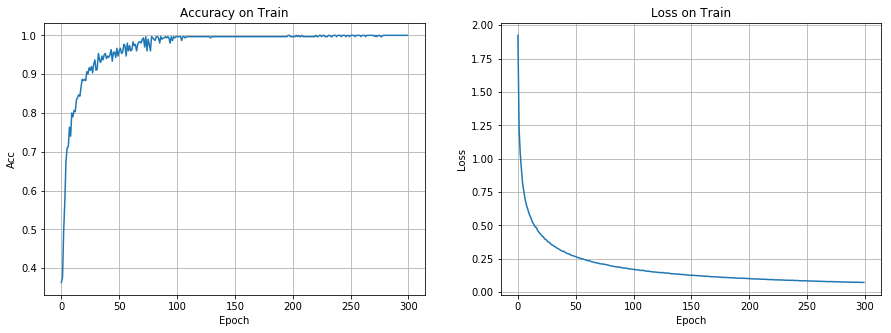

Final Accuracy on Train: 1.000000
Final Loss on Train: 0.073390


In [26]:
model = Sequential()
model.add(Dense(input_dim = X_train.shape[1], units = 3, activation = "softmax", kernel_initializer = "normal"))

sgd = SGD(lr = 1e-4, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])
history = model.fit(X_train, Y_train_onehot, epochs = 300, verbose = 0)
plot_classifier_history(history)

> We can observe that the model with SGD optimizer converges at around 200 epoch. The final accuracy is 100%. During the last 100 epochs, the accuracy floats a little bit.

### ADAM

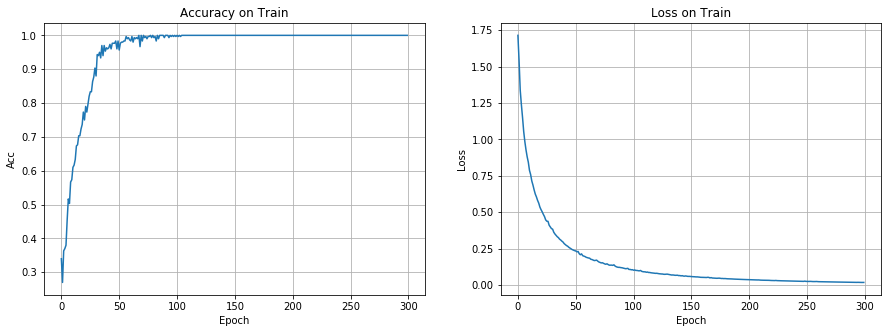

Final Accuracy on Train: 1.000000
Final Loss on Train: 0.017695


In [27]:
model_adam = Sequential()
model_adam.add(Dense(input_dim = X_train.shape[1], units = 3, activation = "softmax", kernel_initializer = "normal"))

adam = Adam(lr = 1e-4, decay = 1e-6)
model_adam.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
history_adam = model_adam.fit(X_train, Y_train_onehot, epochs = 300, verbose = 0)
plot_classifier_history(history_adam)

> Compared to the last model, the one with Adam Optimizer converges faster in this case. The final loss on the training dataset is much lower, which means that the model has more confidence on the softmax probabilities. The accuracy is always 100% after the 105th epoch.

### Test

We generate some new examples and test the ability of our models. The result is satisfying in most cases.

In [28]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
pred_sgd = labels[np.argmax(model.predict(X_test))]
pred_adam = labels[np.argmax(model_adam.predict(X_test))]

print("Test model with a disk:")
print("-" * 30)
print("Model with SGD optimizer : %s" % pred_sgd)
print("Model with ADAM optimizer: %s" % pred_adam)

Test model with a disk:
------------------------------
Model with SGD optimizer : disk
Model with ADAM optimizer: disk


In [29]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
pred_sgd = labels[np.argmax(model.predict(X_test))]
pred_adam = labels[np.argmax(model_adam.predict(X_test))]

print("Test model with a rectangle:")
print("-" * 30)
print("Model with SGD optimizer : %s" % pred_sgd)
print("Model with ADAM optimizer: %s" % pred_adam)

Test model with a rectangle:
------------------------------
Model with SGD optimizer : rectangle
Model with ADAM optimizer: rectangle


In [30]:
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])
pred_sgd = labels[np.argmax(model.predict(X_test))]
pred_adam = labels[np.argmax(model_adam.predict(X_test))]

print("Test model with a triangle:")
print("-" * 30)
print("Model with SGD optimizer : %s" % pred_sgd)
print("Model with ADAM optimizer: %s" % pred_adam)

Test model with a triangle:
------------------------------
Model with SGD optimizer : triangle
Model with ADAM optimizer: triangle


## Task 4 - Visualization of the Solution

In [34]:
def visualize_column(weights, title, labels):
    
    plt.figure(figsize = (20, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(weights[:, 0].reshape((IMAGE_SIZE, IMAGE_SIZE)))
    plt.title("First Column (%s)" % labels[0])
    plt.subplot(1, 3, 2)
    plt.imshow(weights[:, 1].reshape((IMAGE_SIZE, IMAGE_SIZE)))
    plt.title("Second Column (%s)" % labels[1])
    plt.subplot(1, 3, 3)
    plt.imshow(weights[:, 2].reshape((IMAGE_SIZE, IMAGE_SIZE)))
    plt.title("Third Column (%s)" % labels[2])
    plt.suptitle(title)
    plt.show()

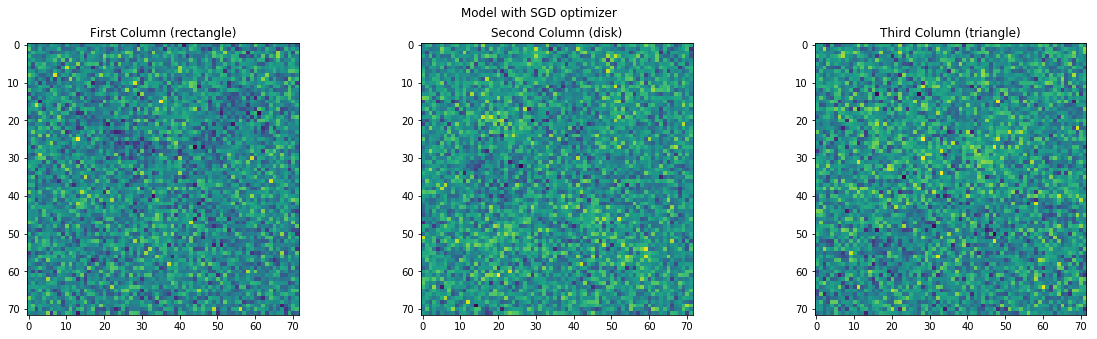

In [35]:
visualize_column(model.get_weights()[0], "Model with SGD optimizer", labels)

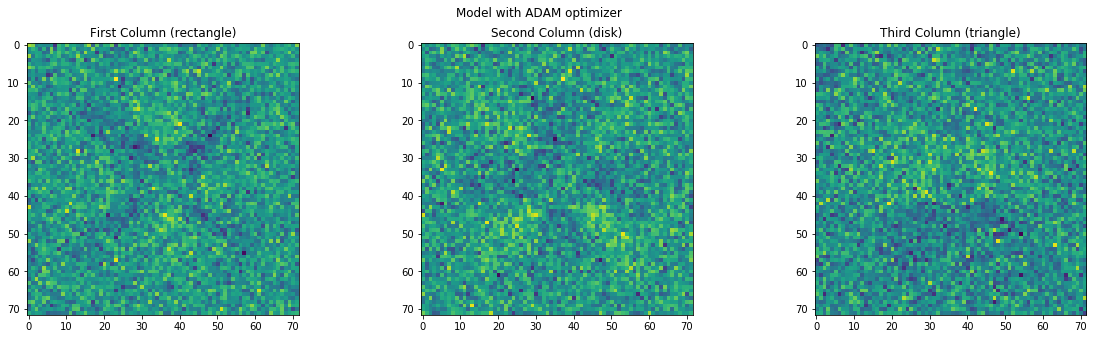

In [36]:
visualize_column(model_adam.get_weights()[0], "Model with ADAM optimizer", labels)

> Each columns is a neuron which computes a weighted average of the input and gives the possibility if the input belongs to the corresponding class. The brighter pixels are highly activated. Since in our task, the drawings are always centered, the patterns are centered as well. 

> We can observe that the *Rectangle* class focus more on the straight edges; the *disk* class focus more on the four round corners which is different from the other classes; the *triangle* class focus more on the two hypotenuses.

## Task 5 - A More Difficult Classification Problem

In this task we generate a more difficult dataset, in which all drawings are not centered any more.

In [37]:
X_train, Y_train = generate_dataset_classification(300, 20, True)
Y_train_onehot = np_utils.to_categorical(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


### SGD

Learning rate increases and decay increases. Train more epoch

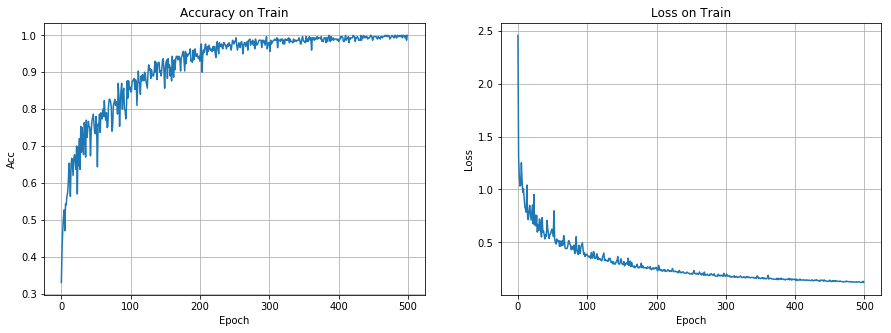

Final Accuracy on Train: 1.000000
Final Loss on Train: 0.121593


In [40]:
model = Sequential()
model.add(Dense(input_dim = X_train.shape[1], units = 3, activation = "softmax", kernel_initializer = "normal"))

sgd = SGD(lr = 1e-3, decay = 1e-4, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])
history = model.fit(X_train, Y_train_onehot, epochs = 500, verbose = 0)
plot_classifier_history(history)

> In this experiment, we do the following changes to make the model adapt to the hard dataset.
> * The learning rate is higher (1e-4 -> 1e-3)
> * We train longer the model (500 epoches)

> From the result we obverse that the model converges slower but the result is still satisfying. The final accuracy on the training dataset is 100% and the optimization is stable.

### ADAM

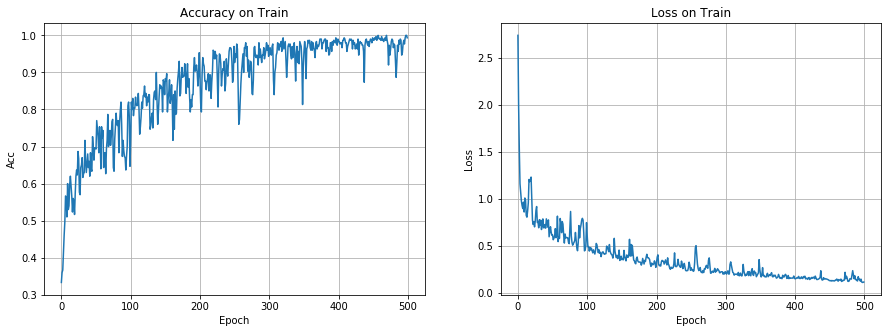

Final Accuracy on Train: 0.993333
Final Loss on Train: 0.115167


In [45]:
model_adam = Sequential()
model_adam.add(Dense(input_dim = X_train.shape[1], units = 3, activation = "softmax", kernel_initializer = "normal"))

adam = Adam(lr = 1e-3, decay = 1e-4)
model_adam.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
history_adam = model_adam.fit(X_train, Y_train_onehot, epochs = 500, verbose = 0)
plot_classifier_history(history_adam)

> In the case of Adam optimizer, the model is not stable due to the lack of training data. Thus if we want to choose a good model, a validation dataset is needed during the training process.

### Test

In [46]:
X_test, Y_test = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [47]:
metric_values = model.evaluate(X_test, Y_test)
metric_names = model.metrics_names

print("Evaluate the model with SGD optimizer:")
print("-" * 30)
for i, metric in enumerate(metric_names):
    print("%5s: %f" % (metric, metric_values[i]))

300/300 [==============================] - 0s 526us/step
Evaluate the model with SGD optimizer:
------------------------------
 loss: 1.205994
  acc: 0.536667


In [48]:
metric_values = model_adam.evaluate(X_test, Y_test)
metric_names = model_adam.metrics_names

print("Evaluate the model with ADAM optimizer:")
print("-" * 30)
for i, metric in enumerate(metric_names):
    print("%5s: %f" % (metric, metric_values[i]))

300/300 [==============================] - 0s 496us/step
Evaluate the model with ADAM optimizer:
------------------------------
 loss: 1.280356
  acc: 0.573333


> We evaluate the model on a new test dataset. The accuracy of the one with Adam optimizer is higher, while the loss of the one with SGD optimizer is lower. 

> The result is not good on both models since the network does not have enough ability to learn this task using such a little dataset.

### Deep Network

We train a more complicated model using more data. The used model is based on an [AllConvNet](https://arxiv.org/abs/1412.6806). It contains 9 conlutional layers with ReLU activation, 2 dropout layers and a global average pooling layer at the end. It achieves a high accuracy on ImageNet.

In [49]:
import tensorflow as tf
from keras.layers import Dropout, Convolution2D, GlobalAveragePooling2D, merge, MaxPool2D, Flatten
from keras import backend as K

In [50]:
X_train, Y_train = generate_dataset_classification(5000, 20, True)
X_train = X_train.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))
Y_train_onehot = np_utils.to_categorical(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [51]:
model_allconv = Sequential()

model_allconv.add(Convolution2D(96, 3, padding = "valid", input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)))
model_allconv.add(Activation("relu"))
model_allconv.add(Convolution2D(96, 3, padding = "valid"))
model_allconv.add(Activation("relu"))
model_allconv.add(Convolution2D(96, 3, padding = "valid", strides = (2, 2)))
model_allconv.add(Dropout(0.5))

model_allconv.add(Convolution2D(192, 3, padding = "valid"))
model_allconv.add(Activation("relu"))
model_allconv.add(Convolution2D(192, 3, padding = "valid"))
model_allconv.add(Activation("relu"))
model_allconv.add(Convolution2D(192, 3, padding = "valid", strides = (2, 2)))
model_allconv.add(Dropout(0.5))

model_allconv.add(Convolution2D(192, 3, padding = "valid"))
model_allconv.add(Activation("relu"))
model_allconv.add(Convolution2D(192, 1, padding = "valid"))
model_allconv.add(Activation("relu"))
model_allconv.add(Convolution2D(3, 1, padding = "valid"))

model_allconv.add(GlobalAveragePooling2D())
model_allconv.add(Activation("softmax"))

sgd = SGD(lr = 0.005, decay = 1e-4, momentum = 0.9, nesterov = True)
model_allconv.compile(loss = "categorical_crossentropy", optimizer = sgd, metrics = ["accuracy"])

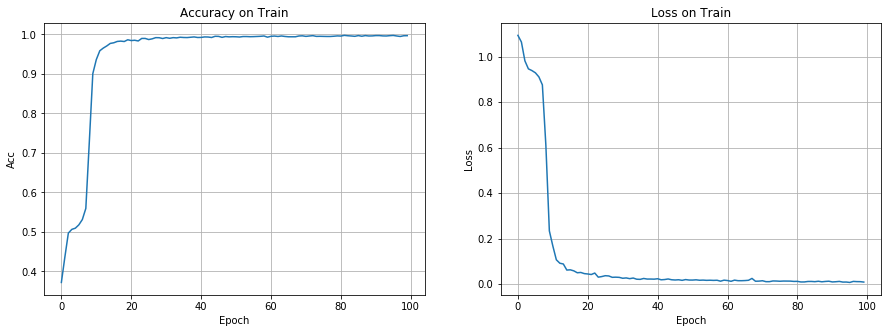

Final Accuracy on Train: 0.996800
Final Loss on Train: 0.009512


In [52]:
history_allconv = model_allconv.fit(X_train, Y_train_onehot, epochs = 100, verbose = 0)
plot_classifier_history(history_allconv)

In [53]:
metric_values = model_allconv.evaluate(X_test.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1)), Y_test)
metric_names = model_allconv.metrics_names

print("Evaluate the model with ADAM optimizer:")
print("-" * 30)
for i, metric in enumerate(metric_names):
    print("%5s: %f" % (metric, metric_values[i]))

300/300 [==============================] - 1s 2ms/step
Evaluate the model with ADAM optimizer:
------------------------------
 loss: 0.032579
  acc: 0.993333


> We train the model for 100 epoches. But in fact it converges very fast (at around the 30th epoch). The final accuracy is much higher and the result on test dataset proves that the model does not overfit our training dataset.

## Task 6 - A Regression Problem

In this task we intend to train a model which can predict the image locations of the vertices of a triangle, given its image. It is a multi-variable regression problem.

> We know that for a triangle, the order of its vertices does not change its shape, but the loss of the model does change. Thus we need to normalize the data label in order that its follows a specific order. 

> In my implementation, I reorder the labels by the acsending order of its x-coordinate.

In [56]:
def reorder_ytrain(Y_train):
    
    idx = np.argsort(Y_train[:, [0, 2, 4]],axis = 1)    
    Y_train_new = np.array([Y_train[np.arange(len(Y_train)), 2 * idx[:, i // 2] + i % 2] for i in range(6)])

    return Y_train_new.T

In [57]:
X_train, Y_train = generate_dataset_regression(5000, 20)
Y_train_new = reorder_ytrain(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

### Visualization

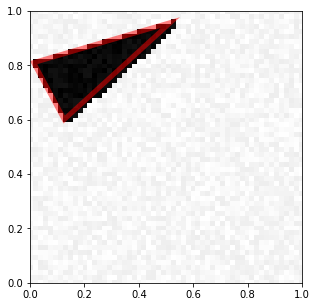

In [58]:
visualize_prediction(X_train[0], Y_train_new[0])

### Model

We use a convolutional neural network containing 3 convolutional layers followed by a ReLU activation, a max pooling and a dropout layer, and 3 fully-connected layers. We calculate the mean squared loss and optimize the model by a SGD optimizer.

In [67]:
model_rg = Sequential()

model_rg.add(Convolution2D(32, 3, padding = "same", input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)))
model_rg.add(Activation('relu'))
model_rg.add(MaxPool2D(pool_size = (2, 2)))
model_rg.add(Dropout(0.1))

model_rg.add(Convolution2D(64, 2, padding = "same"))
model_rg.add(Activation('relu'))
model_rg.add(MaxPool2D(pool_size = (2, 2)))
model_rg.add(Dropout(0.1))

model_rg.add(Convolution2D(128, 2, padding = "same"))
model_rg.add(Activation('relu'))
model_rg.add(MaxPool2D(pool_size = (2, 2)))
model_rg.add(Dropout(0.1))

model_rg.add(Flatten())
model_rg.add(Dense(500, activation='relu'))
model_rg.add(Dropout(0.1))
model_rg.add(Dense(100, activation='relu'))
model_rg.add(Dropout(0.1))

model_rg.add(Dense(6))

sgd = SGD(lr = 0.01, decay = 1e-4, momentum = 0.9,nesterov = True)
model_rg.compile(loss="mean_squared_error", optimizer = sgd)

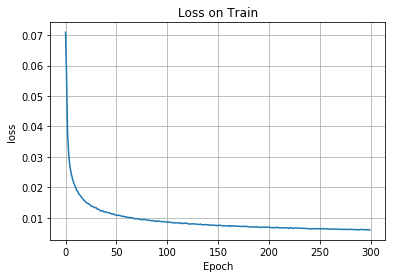

In [68]:
history_rg = model_rg.fit(X_train.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1)), Y_train_new, epochs = 300, verbose = 0)
plot_regression_history(history_rg)

### Test

In [69]:
X_test, Y_test = generate_test_set_regression()
Y_test_new = reorder_ytrain(Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [70]:
metric_values = model_rg.evaluate(X_test.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1)), Y_test_new)

print("Evaluate the model with SGD optimizer:")
print("-" * 30)
print("%s: %f" % ("Loss", metric_values))

300/300 [==============================] - 0s 2ms/step
Evaluate the model with SGD optimizer:
------------------------------
Loss: 0.007513


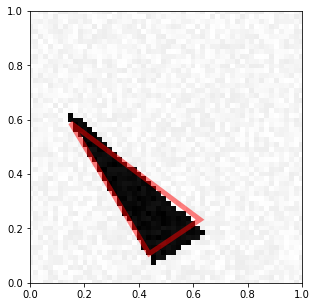

In [72]:
index = 15
Y_test_pred = model_rg.predict(X_test[index].reshape((1, IMAGE_SIZE, IMAGE_SIZE, 1)))
visualize_prediction(X_test[index], Y_test_pred)

> We can observe that the model performs well on both the training dataset and the test dataset. The convergence of the model is also guaranteed. 

## Task 7 - Image Denoising

### Dataset Generation

In [74]:
def generate_dataset_denoising(nb_samples, max_noise=50.0, free_location=True):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples, im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        noise = np.random.randint(max_noise)
        if category == 0:
            Y[i], X[i] = generate_a_rectangle(noise, free_location, pair=True)
        elif category == 1: 
            Y[i], X[i] = generate_a_disk(noise, free_location, pair=True)
        else:
            temp = generate_a_triangle(noise, free_location, pair=True)
            Y[i] = temp[0][0]
            X[i] = temp[0][1]

    return [X.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1)), Y.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))]

In [75]:
def generate_test_set_pair():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300)
    return [X_test, Y_test]

### Visualization

In [76]:
def visualize_data_pair(X, Y):
    plt.plot()
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(X), cmap = "gray")
    plt.title("Noisy Image")
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(Y), cmap = "gray")
    plt.title("Clean Image")
    plt.show()

### Evaluation

In [88]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

### Data

In [77]:
X_train, Y_train = generate_dataset_denoising(5000)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

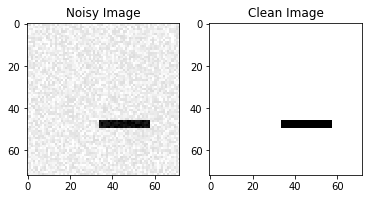

In [79]:
index = 10
visualize_data_pair(X_train[index], Y_train[index])

In [92]:
X_test, Y_test = generate_test_set_pair()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


### Model

Our model is based on [DnCNN](https://arxiv.org/abs/1608.03981). It directly estimates the latent clean image by a deep CNN, the network adopts the residual learning strategy to remove the latent clean image from noisy observation.

In [82]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import  Input, BatchNormalization, Lambda, Subtract
from keras.models import Model

In [81]:
def DnCNN():
    inpt = Input(shape=(None,None,1))
    # 1st layer, Conv+relu
    x = Convolution2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
    x = Activation('relu')(x)
    # 15 layers, Conv+BN+relu
    for i in range(15):
        x = Convolution2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
        x = BatchNormalization(axis=-1, epsilon=1e-3)(x)
        x = Activation('relu')(x)   
    # last layer, Conv
    x = Convolution2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Subtract()([inpt, x])   # input - noise
    model = Model(inputs=inpt, outputs=x)
    
    return model

In [99]:
sgd = SGD(lr = 0.001, decay = 1e-4, momentum = 0.9,nesterov = True)
model_dncnn = DnCNN()
model_dncnn.compile(loss="mean_squared_error", optimizer = sgd)

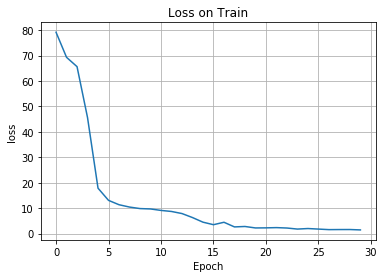

In [100]:
history_dncnn = model_dncnn.fit(X_train, Y_train, epochs = 30, verbose = 0)
plot_regression_history(history_dncnn)

In [107]:
metric_values = model_dncnn.evaluate(X_test, Y_test)

print("Evaluate the model with SGD optimizer:")
print("-" * 30)
print("%s: %f" % ("Loss", metric_values))

300/300 [==============================] - 1s 2ms/step
Evaluate the model with SGD optimizer:
------------------------------
Loss: 6.868222


PSNR (X, Y_true): 27.765155
PSNR (X, Y_hat): 26.408005
PSNR (Y_hat, Y_true): 41.567669
--------------------------------------------------


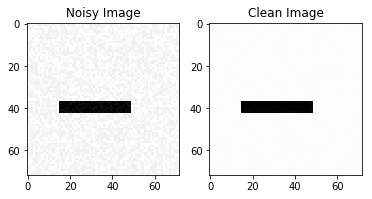

In [105]:
index = 10
Y_test_pred = model_dncnn.predict(X_test[index].reshape((1, IMAGE_SIZE, IMAGE_SIZE, 1)))

print("PSNR (X, Y_true): %f" % (psnr(X_test[index], Y_test[index])))
print("PSNR (X, Y_hat): %f" % (psnr(X_test[index], Y_test_pred)))
print("PSNR (Y_hat, Y_true): %f" % (psnr(Y_test[index], Y_test_pred)))
print("-" * 50)
visualize_data_pair(X_test[index], Y_test_pred)

>  We observe that the DnCNN model is effective. The predicted clean image is quite close to the groundtruth.